# Flight Booking Prediction Model with Random Forest

## Introduction:

This notebook explores the flight booking data of British Airways over the last few years.

## Objective:

 The primary goal of this analysis is to predict whether a customer will complete a booking or not.

## Data Overview:

The dataset comprises the following attributes:

- **num_passengers**: Number of passengers traveling
- **sales_channel**: Sales channel where the booking was made
- **trip_type**: Trip type (Round Trip, One Way, Circle Trip)
- **purchase_lead**: Number of days between travel date and booking date
- **length_of_stay**: Number of days spent at the destination
- **flight_hour**: Hour of flight departure
- **flight_day**: Day of the week of flight departure
- **route**: Origin -> destination flight route
- **booking_origin**: Country from where the booking was made
- **wants_extra_baggage**: If the customer wanted extra baggage in the booking
- **wants_preferred_seat**: If the customer wanted a preferred seat in the booking
- **wants_in_flight_meals**: If the customer wanted in-flight meals in the booking
- **flight_duration**: Total duration of the flight (in hours)
- **booking_complete**: Flag indicating if the customer completed the booking

Let's start!

In [35]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder

In [36]:
df = pd.read_csv('/content/customer_booking.csv', encoding='ISO-8859-1')


In [37]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


# Exploratory Data Analysis

In [38]:
df.shape

(50000, 14)

In [39]:
numerical_features = df.select_dtypes(include=[np.number])
numerical_features.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,9.500000,1.000000


In [40]:
categorical_features = df.select_dtypes(include=[object])
cat_summary_stats = categorical_features.describe().T
print( cat_summary_stats)

                count unique        top   freq
sales_channel   50000      2   Internet  44382
trip_type       50000      3  RoundTrip  49497
flight_day      50000      7        Mon   8102
route           50000    799     AKLKUL   2680
booking_origin  50000    104  Australia  17872


In [41]:
df.columns

Index(['num_passengers', 'sales_channel', 'trip_type', 'purchase_lead',
       'length_of_stay', 'flight_hour', 'flight_day', 'route',
       'booking_origin', 'wants_extra_baggage', 'wants_preferred_seat',
       'wants_in_flight_meals', 'flight_duration', 'booking_complete'],
      dtype='object')

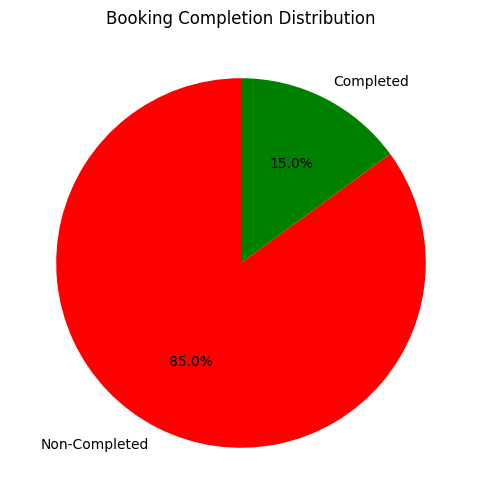

In [42]:
booking_counts = df['booking_complete'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(booking_counts, labels=['Non-Completed', 'Completed'], autopct='%1.1f%%', startangle=90, colors=['red', 'green'])
plt.title('Booking Completion Distribution')
plt.show()

<ipython-input-43-f96464a2691e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


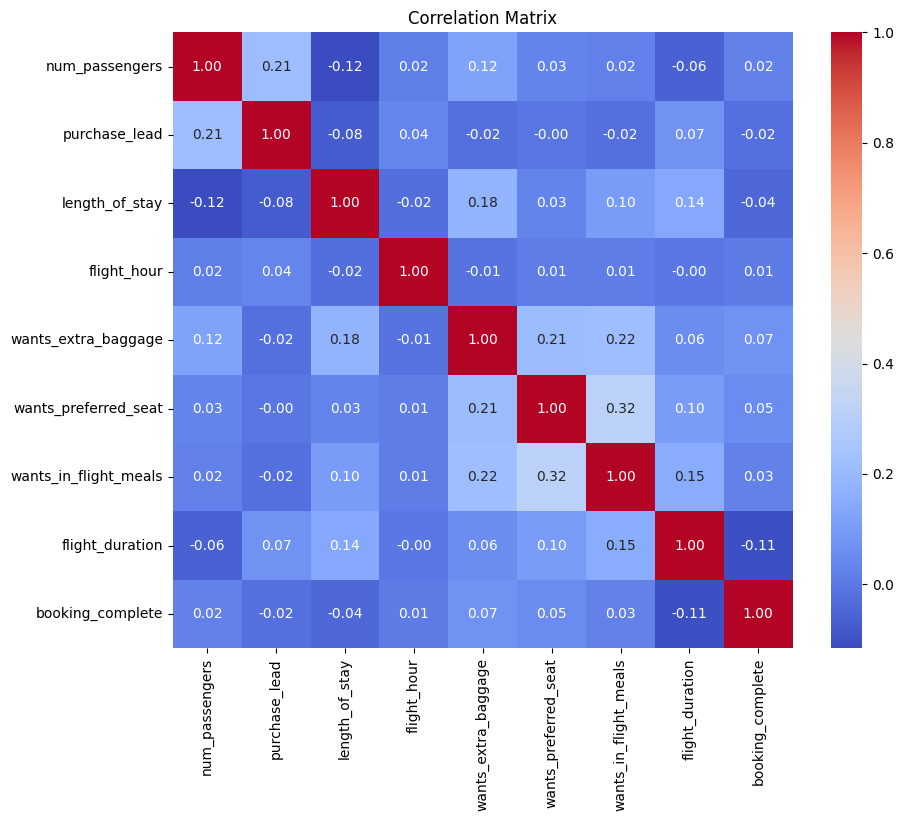

In [43]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


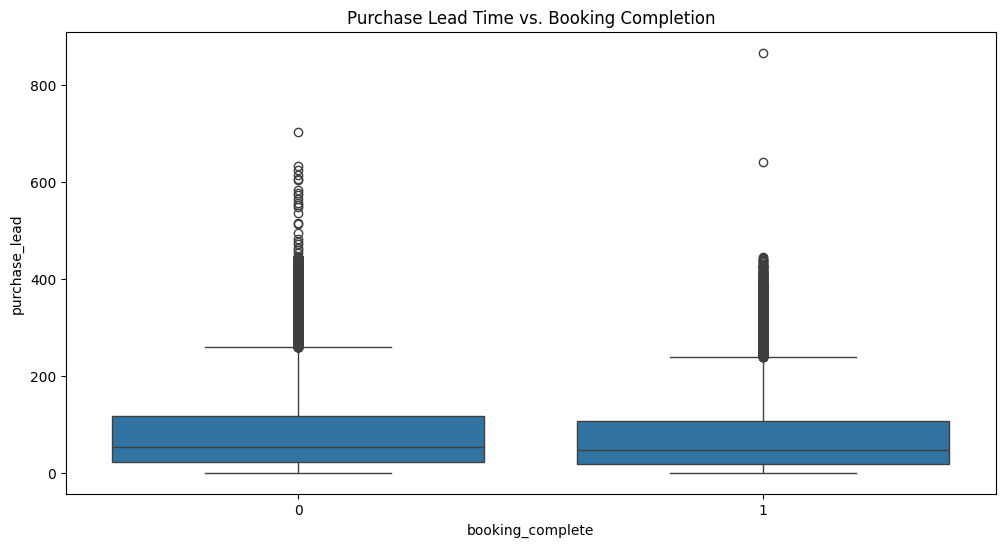

In [44]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='booking_complete', y='purchase_lead', data=df)
plt.title('Purchase Lead Time vs. Booking Completion')
plt.show()


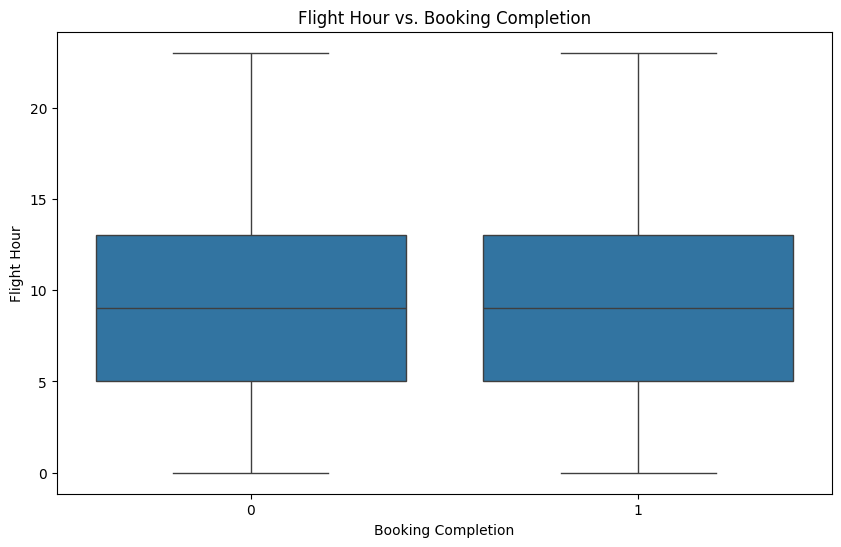

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(x='booking_complete', y='flight_hour', data=df)
plt.title('Flight Hour vs. Booking Completion')
plt.xlabel('Booking Completion')
plt.ylabel('Flight Hour')
plt.show()


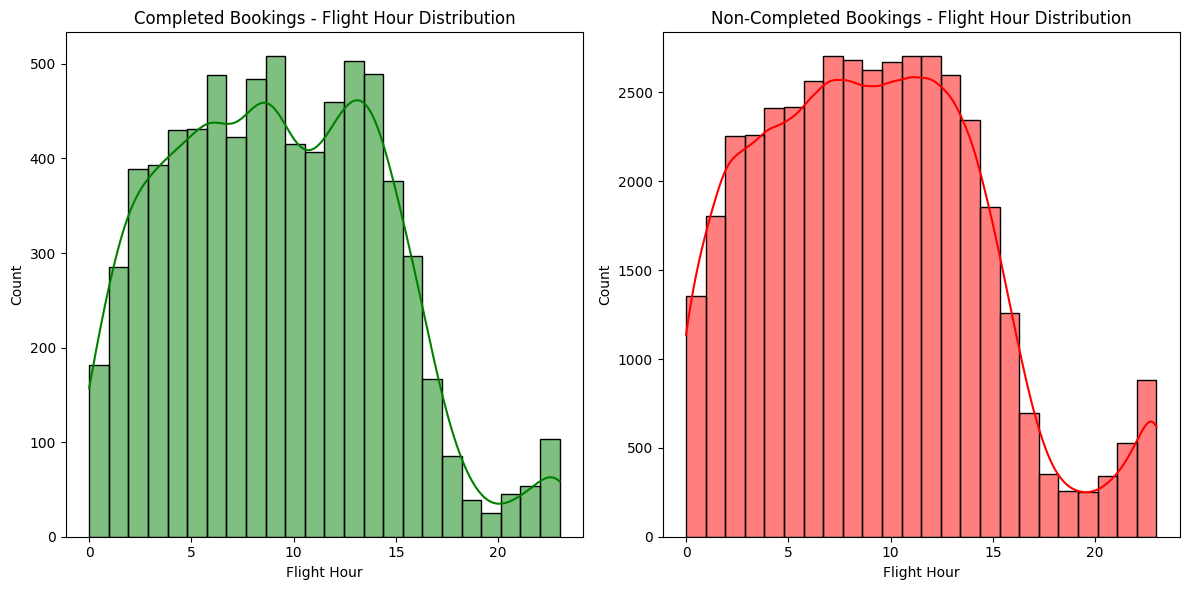

In [46]:
completed_bookings = df[df['booking_complete'] == 1]
non_completed_bookings = df[df['booking_complete'] == 0]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(completed_bookings['flight_hour'], bins=24, kde=True, color='green')
plt.title('Completed Bookings - Flight Hour Distribution')
plt.xlabel('Flight Hour')
plt.subplot(1, 2, 2)
sns.histplot(non_completed_bookings['flight_hour'], bins=24, kde=True, color='red')
plt.title('Non-Completed Bookings - Flight Hour Distribution')
plt.xlabel('Flight Hour')

plt.tight_layout()
plt.show()


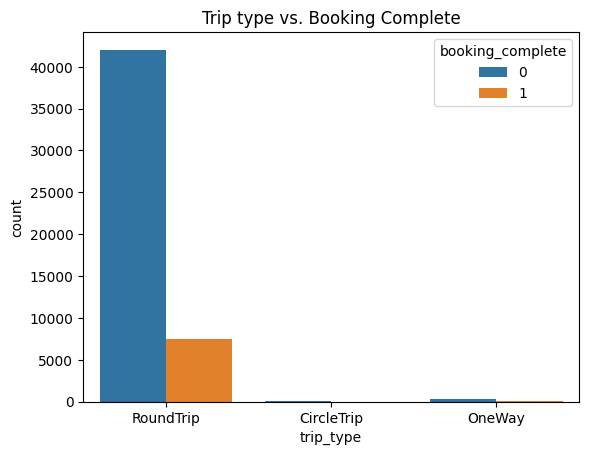

In [47]:
sns.countplot(x="trip_type", hue="booking_complete", data=df)
plt.title("Trip type vs. Booking Complete")
plt.show()


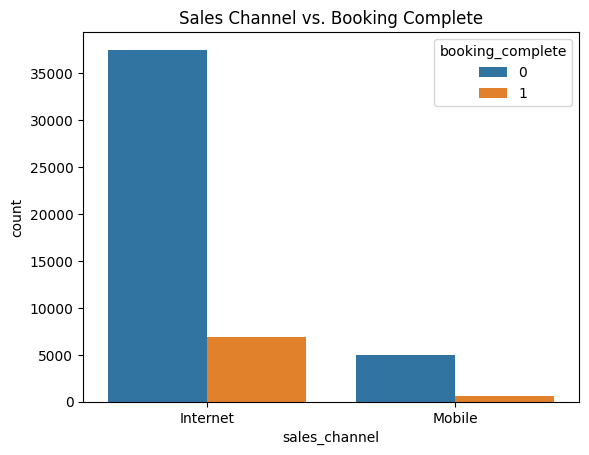

In [48]:
sns.countplot(x="sales_channel", hue="booking_complete", data=df)
plt.title("Sales Channel vs. Booking Complete")
plt.show()


In [22]:
print("Target Variable Distribution:\n", df['booking_complete'].value_counts())

Target Variable Distribution:
 0.0    28970
1.0     4093
Name: booking_complete, dtype: int64


# Model training and testing

In [76]:
X = df.drop('booking_complete', axis=1)
y = df['booking_complete']

X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")


Accuracy: 0.8541
Confusion Matrix:
[[8350  170]
 [1289  191]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      8520
           1       0.53      0.13      0.21      1480

    accuracy                           0.85     10000
   macro avg       0.70      0.55      0.56     10000
weighted avg       0.82      0.85      0.81     10000

